### ANALYZE PSEI PRICE PERFORMANCE USING SENTIMENTAL AND NUMERICAL ANALYSIS, AND FORECAST PRICE USING MACHINE LEARNING (PART 2)

##### Forecasting using Autoregressive Moving Average (ARIMA) Model 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
#Import dataset
df_price = pd.read_csv('C:/Users/Jan/Desktop/JAN/GRIP-INTERNSHIP/PSEI-Analysis/PSEI(2014-2023).csv')
#Transform dataset
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_price = df_price.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df_price = df_price.dropna().set_index('Date').sort_values(by='Date')
display(df_price)

,Close
Date,
2014-01-02,5984.259766
2014-01-03,5947.930176
2014-01-06,5985.810059
2014-01-07,5947.439941
2014-01-08,5986.479980
...,...
2023-05-08,6600.740234
2023-05-09,6622.609863
2023-05-10,6658.589844


In [3]:
# Stationarity test using Augmented Dickey-Fuller(ADF) test
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(df_price['Close'])

# Print the results
print("ADF Statistic:", ADF_result[0])
print("p-value:", ADF_result[1])
print("Critical Values:")
for key, value in ADF_result[4].items():
    print("\t{}: {}".format(key, value))

ADF Statistic: -2.948921315061189
p-value: 0.039947732001244046
Critical Values:
	1%: -3.4332289345062725
	5%: -2.86281184241882
	10%: -2.567447060364226


Interpretation: The sample is stationary.

##### Get ARIMA Parameters p, d, q

In [4]:
from pmdarima.arima.utils import ndiffs
# d = degree of differenceing, the number of times that the raw observations are differenced
ndiff = ndiffs(df_price.Close)
print('d value is:', ndiff)

d value is: 1


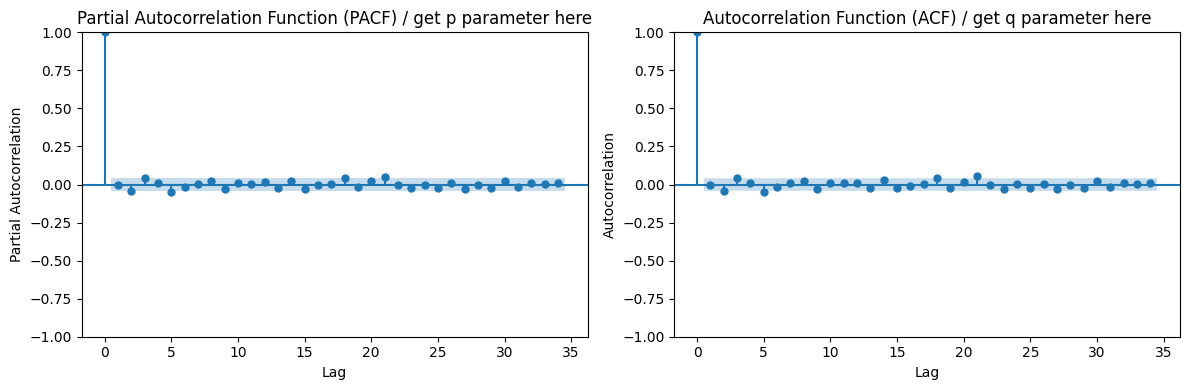

In [5]:
# GET PARAMETERS THROUGH VISUAL INSPECTION
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

diff = df_price.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# Plot PACF
plot_pacf(diff, ax=ax1)
ax1.set_xlabel('Lag')
ax1.set_ylabel('Partial Autocorrelation')
ax1.set_title('Partial Autocorrelation Function (PACF) / get p parameter here')
# Plot ACF
plot_acf(diff, ax=ax2)
ax2.set_xlabel('Lag')
ax2.set_ylabel('Autocorrelation')
ax2.set_title('Autocorrelation Function (ACF) / get q parameter here')
plt.tight_layout()
plt.show()

p = lag order, the number of lag observations included in the model.
d = degree of differenceing, the number of times that the raw observations are differenced.
q = order of moving average, the size of the moving average window.

If the spike in the lag is at lag zero (i.e., the first data point itself), it suggests a strong autocorrelation at lag 1 and indicates the presence of a trend or a unit root in the time series data. In such cases, an autoregressive (AR) component in the ARIMA model can capture the trend.

When the spike is at lag zero, it means that the current value of the time series is highly correlated with its immediate preceding value. This suggests that the time series has a strong persistence or memory from one observation to the next. Considering the spike at lag zero, a reasonable choice would be to modify the order parameter to (p, q) = (1, 0). This means including an autoregressive component of order 1 (AR(1)) and no moving average component. Including an AR(1) component will account for the autocorrelation at lag 1, capturing the trend and the dependency of the current value on the immediate preceding value.
Hence, (1, 0, 0)

In [6]:
data_ARIMA = df_price['Close'].values
model_ARIMA = (ARIMA(data_ARIMA, order=(1, 0, 1)))
model_fit = model_ARIMA.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2280
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -13253.434
Date:                Sun, 04 Jun 2023   AIC                          26514.868
Time:                        05:40:50   BIC                          26537.796
Sample:                             0   HQIC                         26523.231
                               - 2280                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7189.6603    242.727     29.620      0.000    6713.924    7665.396
ar.L1          0.9935      0.002    455.361      0.000       0.989       0.998
ma.L1          0.0028      0.014      0.195      0.8

In [7]:
# Forecast price until May 2024
forecast_ARIMA = model_fit.forecast(steps=260)

In [8]:
# Create dataframe to store the model's prediction
last_date = df_price.index[-1]
future_dates = pd.bdate_range(start=last_date + pd.DateOffset(days=1), periods=260)
df_forecast_Arima = pd.DataFrame()
df_forecast_Arima['Date'] = future_dates
df_forecast_Arima['Close'] = forecast_ARIMA
display(df_forecast_Arima)

,Date,Close
0,2023-05-15,6581.841660
1,2023-05-16,6585.793555
2,2023-05-17,6589.719755
3,2023-05-18,6593.620427
4,2023-05-19,6597.495739
...,...,...
255,2024-05-06,7074.478350
256,2024-05-07,7075.227236
257,2024-05-08,7075.971253
258,2024-05-09,7076.710433


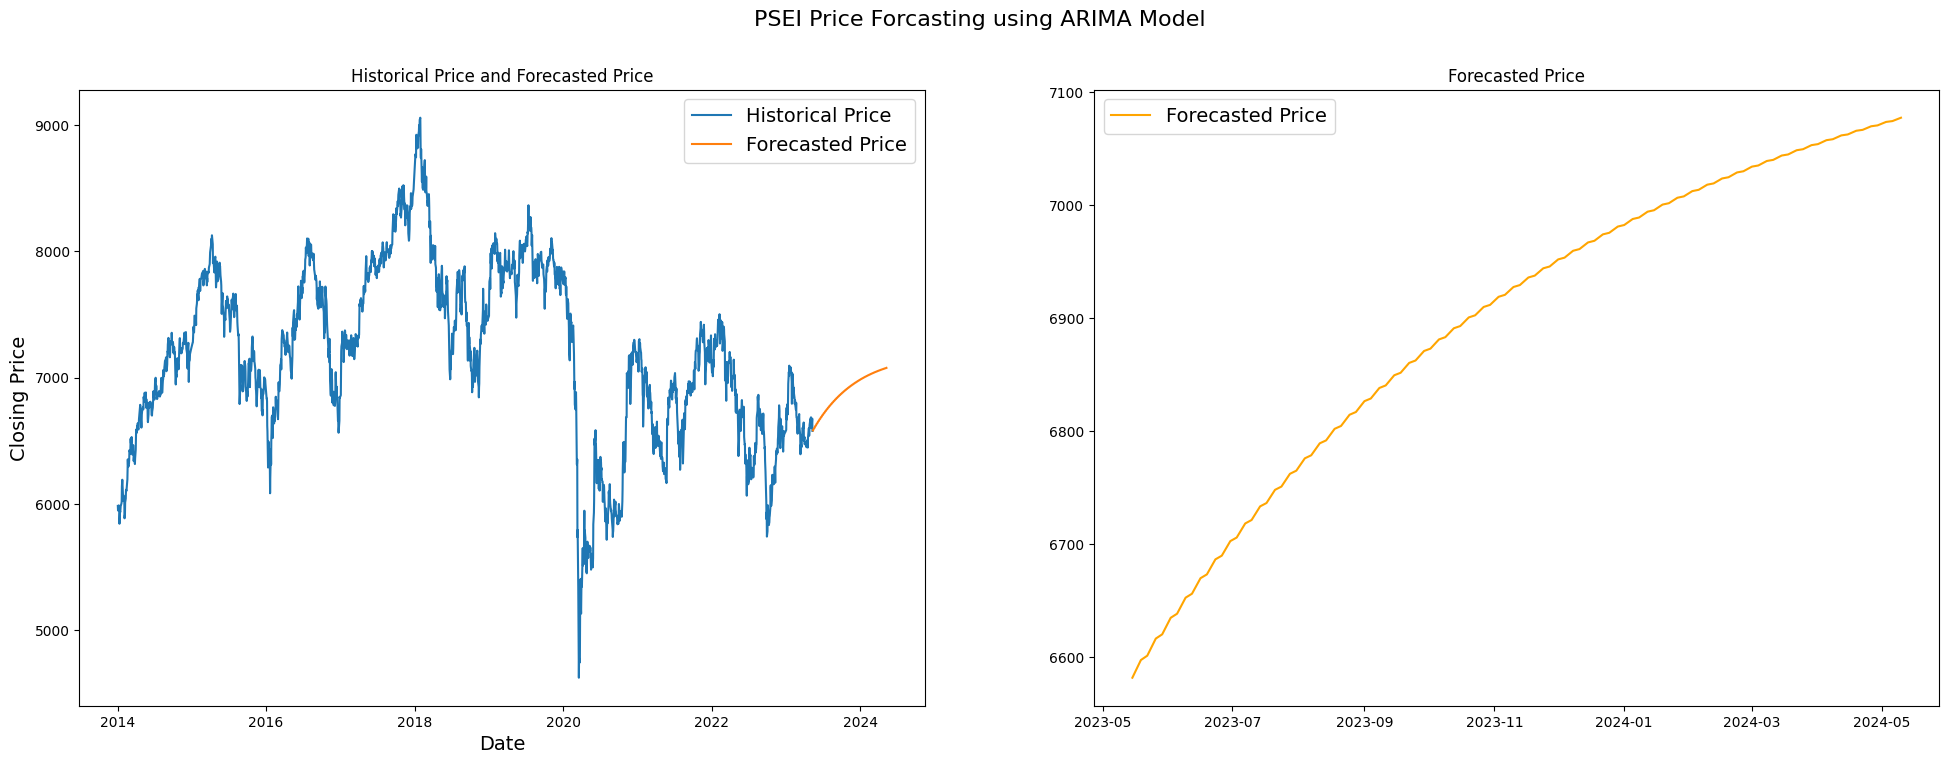

In [9]:
# Visualize results
plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(df_price.index, df_price['Close'], label = 'Historical Price')
plt.plot(df_forecast_Arima['Date'], df_forecast_Arima['Close'], label = 'Forecasted Price')
plt.title('Historical Price and Forecasted Price')
plt.legend(fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)
plt.subplot(1, 2, 2)
plt.plot(future_dates, forecast_ARIMA, color='orange' ,label = 'Forecasted Price')
plt.title('Forecasted Price')
plt.legend(fontsize=14)
plt.suptitle('PSEI Price Forcasting using ARIMA Model', fontsize=16)
plt.show()

In [10]:
# df_forecast_Arima.to_excel('df_forecast_Arima.xlsx', index=False)